# Batch Bayesian Optimization with Batch Expected Improvement, Local Penalization and GIBBON

Sometimes it is practically convenient to query several points at a time. This notebook demonstrates three ways to perfom batch Bayesian optimization with `trieste`.

In [1]:
import numpy as np
import tensorflow as tf
from util.plotting import create_grid, plot_acq_function_2d
from util.plotting_plotly import plot_function_plotly
import matplotlib.pyplot as plt
import trieste

np.random.seed(1234)
tf.random.set_seed(1234)

## Describe the problem

In this example, we consider the same problem presented in our `expected_improvement` notebook, i.e. seeking the minimizer of the two-dimensional Branin function.

We begin our optimization after collecting five function evaluations from random locations in the search space.

In [2]:
from trieste.objectives import scaled_branin, SCALED_BRANIN_MINIMUM
from trieste.objectives.utils import mk_observer
from trieste.space import Box

observer = mk_observer(scaled_branin)
search_space = Box([0, 0], [1, 1])

num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

## Surrogate model
Just like in purely sequential optimization, we fit a surrogate Gaussian process model to the initial data.

In [3]:
import gpflow
from trieste.models import create_model
from trieste.utils import map_values
import tensorflow_probability as tfp


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    prior_scale = tf.cast(1.09, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(tf.cast(-2.0, dtype=tf.float64), prior_scale)
    kernel.lengthscales.prior = tfp.distributions.LogNormal(tf.math.log(kernel.lengthscales), prior_scale)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return {
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    }


model_spec = build_model(initial_data)
model = create_model(model_spec)

## Batch acquisition functions.
To perform batch BO, we must define a batch acquisition function. Three batch acquisition functions supported in Trieste are `BatchMonteCarloExpectedImprovement`, `LocalPenalizationAcquisitionFunction` and `GIBBON`. 

Although all these acquisition functions recommend batches of diverse query points, the batches are chosen in very different ways. `BatchMonteCarloExpectedImprovement` jointly allocates the batch of points as those with the largest expected improvement over our current best solution. In contrast, the `LocalPenalizationAcquisitionFunction` greedily builds the batch, sequentially adding the maximizers of the standard (non-batch) `ExpectedImprovement` function penalized around the current pending batch points. `GIBBON` also builds batches in a greedy manner but seeks batches that provide a large reduction in our uncertainty around the maximum value of the objective function.

In practice, `BatchMonteCarloExpectedImprovement` can be expected to have superior performance for small batches (`batch_size`<5) but scales poorly for larger batches.

Note that all these acquisition functions have controllable parameters. In particular, `BatchMonteCarloExpectedImprovement` is computed using a Monte-Carlo method (so it requires a `sample_size`), but uses a reparametrisation trick to make it deterministic. The `LocalPenalizationAcquisitionFunction` has parameters controlling the degree of penalization that must be estimated from a random sample of `num_samples` model predictions (we recommend at least 1_000 for each search space dimension). Similarly, `GIBBON` requires a `grid_size` parameter that controls its approximation accuracy (which should also be larger than 1_000 for each search space dimension).


First, we collect the batch of ten points recommended by `BatchMonteCarloExpectedImprovement` ...

In [4]:
from trieste.acquisition import BatchMonteCarloExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization

batch_ei_acq = BatchMonteCarloExpectedImprovement(sample_size=1000, jitter=1e-5)
batch_ei_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=10, builder=batch_ei_acq)
points_chosen_by_batch_ei, _ = batch_ei_acq_rule.acquire_single(search_space, initial_data, model)

then we do the same with `LocalPenalizationAcquisitionFunction` ...

In [5]:
from trieste.acquisition import LocalPenalizationAcquisitionFunction

local_penalization_acq = LocalPenalizationAcquisitionFunction(search_space, num_samples=2000)
local_penalization_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=10, builder=local_penalization_acq)
points_chosen_by_local_penalization, _ = local_penalization_acq_rule.acquire_single(
    search_space, initial_data, model)

and finally we use `GIBBON`.

In [6]:
from trieste.acquisition import GIBBON

gibbon_acq = GIBBON(search_space, grid_size = 2000)
gibbon_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=10, builder=gibbon_acq)
points_chosen_by_gibbon, _ = gibbon_acq_rule.acquire_single(
    search_space, initial_data, model)

We can now visualize the batch of 10 points chosen by each of these methods overlayed on the standard `ExpectedImprovement` acquisition function. `BatchMonteCarloExpectedImprovement` chooses a more diverse set of points, whereas `LocalPenalizationAcquisitionFunction` and `GIBBON` focus evaluations in the most promising areas of the space.

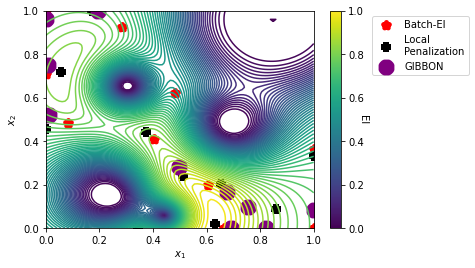

In [7]:
from trieste.acquisition import ExpectedImprovement

# plot standard EI acquisition function
ei = ExpectedImprovement()
ei_acq_function = ei.prepare_acquisition_function(initial_data, model)
plot_acq_function_2d(ei_acq_function, [0, 0], [1, 1], contour=True, grid_density=100)

plt.scatter(
    points_chosen_by_batch_ei[:, 0],
    points_chosen_by_batch_ei[:, 1],
    color="red",
    lw=5,
    label="Batch-EI",
    marker="*",
    zorder=1,
)
plt.scatter(
    points_chosen_by_local_penalization[:, 0],
    points_chosen_by_local_penalization[:, 1],
    color="black",
    lw=10,
    label="Local \nPenalization",
    marker="+",
)
plt.scatter(
    points_chosen_by_gibbon[:, 0],
    points_chosen_by_gibbon[:, 1],
    color="purple",
    lw=10,
    label="GIBBON",
    marker="X",
)


plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
cbar = plt.colorbar()
cbar.set_label("EI", rotation=270)

## Run the batch optimization loop
We can now run a batch Bayesian optimization loop by defining a `BayesianOptimizer` with one of our batch acquisition functions.

We reuse the same ` EfficientGlobalOptimization` rule as in the purely sequential case, however we pass in one of batch acquisition functions and set `num_query_points`>1.

We'll run each method for ten steps for batches of three points.

First we run ten steps of `BatchMonteCarloExpectedImprovement` ...

In [8]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

batch_ei_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=batch_ei_acq
)
qei_result = bo.optimize(10, initial_data, model, acquisition_rule=batch_ei_rule)

Optimization completed without errors


then we repeat the same optimization with `LocalPenalizationAcquisitionFunction`...

In [9]:
local_penalization_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=local_penalization_acq
)
local_penalization_result = bo.optimize(
    10, initial_data, model, acquisition_rule=local_penalization_rule
)

Optimization completed without errors


and finally with the `GIBBON` acquisition function.

In [10]:
gibbon_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=gibbon_acq
)
gibbon_result = bo.optimize(
    10, initial_data, model, acquisition_rule=gibbon_rule
)

Optimization completed without errors


We can visualize the performance of each of these methods by plotting the trajectory of the regret (suboptimality) of the best observed solution as the optimization progresses. We denote this trajectory with the orange line, the start of the optimization loop with the blue line and the best overall point as a purple dot.

For this particular problem (and random seed), we see that `GIBBON` provides the fastest initial optimization and both `GIBBON` and `LocalPenalizationAcquisitionFunction` are able to find solutions with a magnitude smaller regret than `BatchMonteCarloExpectedImprovement`.

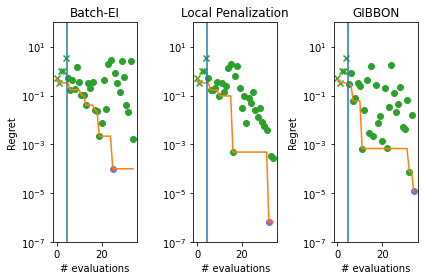

In [11]:
from util.plotting import plot_regret

qei_observations = qei_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
qei_min_idx = tf.squeeze(tf.argmin(qei_observations, axis=0))
local_penalization_observations = (
    local_penalization_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
)
local_penalization_min_idx = tf.squeeze(tf.argmin(local_penalization_observations, axis=0))
gibbon_observations = gibbon_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
gibbon_min_idx = tf.squeeze(tf.argmin(gibbon_observations, axis=0))




fig, ax = plt.subplots(1, 3)
plot_regret(qei_observations.numpy(), ax[0], num_init=5, idx_best=qei_min_idx)
ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.0000001, 100)
ax[0].set_xlabel("# evaluations")
ax[0].set_title("Batch-EI")

plot_regret(local_penalization_observations.numpy(), ax[1], num_init=5, idx_best=local_penalization_min_idx)
ax[1].set_yscale("log")
ax[1].set_xlabel("# evaluations")
ax[1].set_ylim(0.0000001, 100)
ax[1].set_title("Local Penalization")

plot_regret(gibbon_observations.numpy(), ax[2], num_init=5, idx_best=gibbon_min_idx)
ax[2].set_yscale("log")
ax[2].set_ylabel("Regret")
ax[2].set_ylim(0.0000001, 100)
ax[2].set_xlabel("# evaluations")
ax[2].set_title("GIBBON")

fig.tight_layout()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)